In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys; sys.path.insert(0, "../")
import numpy as np
import time

from pandas import DataFrame
import seaborn as sns

from emcee.autocorr import *
from ensemble_sampler import *

# Example of sampling from a multivariate gaussian

## Define distribution

In [3]:
dim = 2
nwalkers = 50
niters = 10000

mu = np.zeros(dim)
cov = np.identity(dim)
t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

## pCN, proposal beta=0.8. 

In [6]:
proposal = PCNWalkMove(beta=0.8)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=25, random_start=True, store=True, store_every=niters, title='test')

end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

saving to ./results/test.hdf5...
finishes in about 11.52 seconds
auto-correlation time: [ 5.51060161  5.1911635 ]


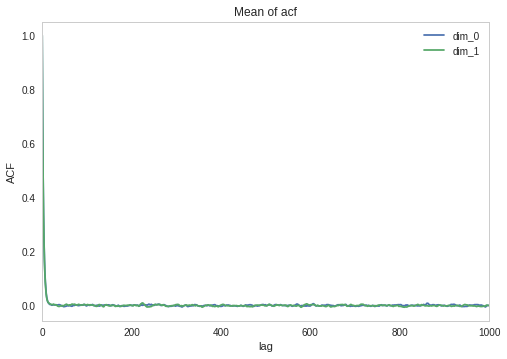

In [7]:
chain = sampler.history.get('chain')
acf = plot_acf(chain, mean_first=False, max_lag=1000)

In [8]:
np.mean(sampler.history.acceptance_rate)

0.83737799999999996

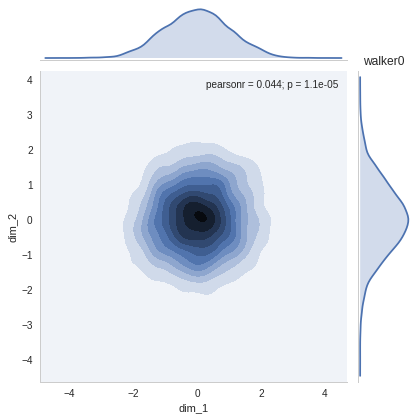

In [9]:
chain = sampler.history.get('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[0, :, 0], chain[0, :, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')
sns.plt.title('walker%s' % 0)

### Real Exps.
#### 1. Change of ACT w.r.t. beta, dim=2, nwalkers=10

In [11]:
dim = 2
nwalkers = 10
niters = 10000

mu = np.zeros(dim)
cov = np.identity(dim)
t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

steps = 20
act = np.zeros([steps, dim])

betas = np.linspace(0, 1, steps, endpoint=False) + 1e-8
for i in range(steps):
    proposal = PCNWalkMove(beta=betas[i])
    sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

    start = time.time()
    sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True, store_every=niters, title='test_1')

    end = time.time()
    print 'finishes step %d in about %.2f seconds' % (i, float(end - start))
    try:
        act[i, :] = sampler.auto_corr()
    except AutocorrError, err:
        pass

saving to ./results/test_1.hdf5...
finishes step 0 in about 56.03 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 1 in about 51.37 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 2 in about 51.23 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 3 in about 51.22 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 4 in about 51.19 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 5 in about 51.34 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 6 in about 51.56 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 7 in about 51.26 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.hdf5...
finishes step 8 in about 50.92 seconds
removing ./results/test_1.hdf5...
saving to ./results/test_1.h

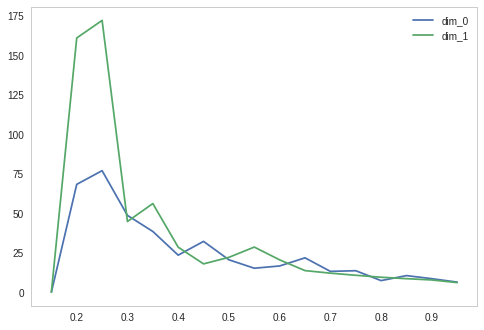

In [12]:
for i in range(dim):
    plt.plot(betas[3:], act[3:, i], label='dim_%s' % i)
plt.legend()

#### 2. Change of acceptance rate w.r.t. dimension, beta=0.8, nwalkers=20

In [6]:
dims = [2, 5, 10, 20, 40]
nwalkers = 50
niters = 10000

accept = np.zeros_like(dims)


for k in range(len(dims)):
    dim = dims[k]
    mu = np.zeros(dim)
    cov = np.identity(dim)
    t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

    proposal = PCNWalkMove(beta=0.4)
    sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

    start = time.time()
    sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True, store_every=niters, title='test')

    end = time.time()
    print 'finishes step %d in about %.2f seconds' % (k, float(end - start))
    accept[k] = np.mean(sampler.history.acceptance_rate)

removing ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes step 0 in about 249.95 seconds
removing ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes step 1 in about 278.59 seconds
removing ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes step 2 in about 335.72 seconds
removing ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes step 3 in about 708.01 seconds
removing ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes step 4 in about 1490.68 seconds


In [9]:
sampler.history.acceptance_rate

array([[ 0.    ],
       [ 0.    ],
       [ 0.0071],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.0001],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.0022],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.0001],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ],
       [ 0.    ]])